# NO2 Data Report

After downloading the data and preparing it, we obtained a no2 dataset with daily averages for processing, which is the one used for this report.

The first section of code contains the libraries and some helper functions for plotting and processing the data.

Second section contains data preparation for the no2 dataset.

Third section provides a plot of the exceedence rate of each sensor for each month to check temporal and spatial variability.

Fourth section provides some interpolations to see the spatial variability and the effect of different interpolation methods in the pollution maps produced from the data.

## Section 1 - Imports and helper functions

In [1]:
import sys
sys.path.append("../../../..")

# Import the necessary libraries
from datetime import date
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

#This is a interpolation module that uses scipy interpolation methods.
from modules import interpolation_module as interp

2025-03-02 11:58:17.614885: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 11:58:17.616060: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 11:58:17.638350: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 11:58:17.639037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-02 11:58:18.008550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
#Helper function for plotting DataFrames
def show_plot(df, x_col, y_col, name="Unnamed Plot", limits=[], print=False):
    if type(df) != list:
        df = [df]
        x_col = [x_col]
        y_col = [y_col]
        name = [name]
    
    fig = go.Figure()
    for i, single_df in enumerate(df):
        x = single_df[x_col[i]]
        y = single_df[y_col[i]]
        fig_name = name[i]
        if print:
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers',line=dict(width=10),marker_size=20,name=fig_name))
        else:
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers',name=fig_name))
            
    
    if len(limits) > 0:
        for limit in limits:
            thr = limit['thr']
            name = limit['name']
            #fig.add_trace(trace)
            fig.add_hline(y=thr, line_width=2, line_dash="dot", line_color="black", annotation_text=name)
    
    # Set white background color
    if print:
        fig.update_layout(
            width=3600,
            height=1600,
            font=dict(
                size=50,
            ),
            plot_bgcolor='white',   # Background of the plot area (white)
            paper_bgcolor='white',  # Background of the entire figure (white)
            xaxis=dict(showgrid=True, gridcolor='lightgray',title='Date'),  # Keep grid lines
            yaxis=dict(showgrid=True, gridcolor='lightgray',title='μg/m3')   # Keep grid lines
        )
    
    fig.show()

In [3]:
#function to import the csv file and do some preprocessing
def import_df(path, start_year, end_year, date_format="%Y-%m-%d", date_column="date"):
    df = pd.read_csv(path, index_col = 0)
    if date_format is not None and date_column is not None:
        df[date_column] = pd.to_datetime(df[date_column],  format=date_format)
    df = df.loc[
        (df['date'].dt.year >= start_year) &
        (df['date'].dt.year <= end_year)
    ]
    #df = df.replace(-9999.0, np.nan).dropna()
    return df

## Section 2 - Data Preparation

Here we set the daily theshold according to EU regulations. The regulation states that for no2 the daily average threshold should be a maximum of 50 µg/m3.

Then, data of no2 daily avergaes is imported as a DataFrame and the dates are converted to datetime for further processing and filter.

A new column ("exceed") is added to the DataFrame as a binary classification to determine if the value at a set date exceedes the daily threshold.

From the data, we also can see that the no2 data ranges from February 1998 to February 2023. In total, 9122 days.

In [4]:
"""
Pollutant   daily     exceedances per year
no2        25        
"""
no2_daily_threshold = 50 #ug/m3
no2_yearly_threshold = 40

# Using the row daily no2 data.
no2_file_path = "../../data/milano_pollutant_data/no2_hourly.csv"
start_year = 1998
end_year = 2023
no2_data = import_df(no2_file_path, start_year, end_year, date_format="%Y-%m-%d")

/tmp/ipykernel_39986/994579827.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col = 0)


In [5]:
#Add binary column for defining if a day exceeds the threshold [0: no, 1: yes]
no2_data['exceed'] = np.where(no2_data['value'].gt(no2_daily_threshold), 1, 0)

In [6]:
no2_data = no2_data.sort_values('date')
unique_days = no2_data.date.unique()
initial_day = unique_days[0]
final_day = unique_days[-1]
total_days = (final_day - initial_day).astype("timedelta64[D]") #9122 days
print(f'Initial Date: {initial_day}')
print(f'Final Date: {final_day}')
print(f'Total Days: {total_days}')

Initial Date: 1998-01-01T00:00:00.000000000
Final Date: 2023-12-31T00:00:00.000000000
Total Days: 9495 days


In [7]:
no2_data.describe()

sensor_id           lat           lng         value        exceed
count  2.349571e+06  2.349571e+06  2.349571e+06  2.349571e+06  2.349571e+06
mean   5.822198e+03  4.547130e+01  9.187407e+00  5.507836e+01  5.054204e-01
std    1.133626e+03  3.148551e-02  7.260806e-02  3.234363e+01  4.999707e-01
min    5.504000e+03  4.528196e+01  8.736497e+00  0.000000e+00  0.000000e+00
25%    5.506000e+03  4.546242e+01  9.167945e+00  3.010000e+01  0.000000e+00
50%    5.542000e+03  4.547323e+01  9.190934e+00  5.050000e+01  1.000000e+00
75%    5.551000e+03  4.549632e+01  9.222315e+00  7.390000e+01  1.000000e+00
max    1.027900e+04  4.555233e+01  9.515980e+00  3.271000e+02  1.000000e+00

In [8]:
no2_data

sensor_id                 station        lat       lng       date  \
1800407       5531         Milano Verziere  45.463347  9.195325 1998-01-01   
1201511       5506  Milano P.zza Zavattari  45.476063  9.141786 1998-01-01   
1533431       5506  Milano P.zza Zavattari  45.476063  9.141786 1998-01-01   
2318351       5550     Milano Parco Lambro  45.499584  9.247327 1998-01-01   
2522399       5550     Milano Parco Lambro  45.499584  9.247327 1998-01-01   
...            ...                     ...        ...       ...        ...   
171745        5548                     NaN  45.281956  8.988563 2023-12-31   
205399        5551                     NaN  45.470499  9.197460 2023-12-31   
188826        5549                     NaN  45.462416  8.880210 2023-12-31   
137021        5542                     NaN  45.443858  9.167945 2023-12-31   
272578       10279                     NaN  45.478996  9.235491 2023-12-31   

         value  exceed  
1800407   84.1       1  
1201511   80.3       1  
1533431   80.3       1  
2318351   62.8       1  
2522399   62.8       1  
...        ...     ...  
171745    34.8       0  
205399    46.4       0  
188826    39.0       0  
137021    40.7       0  
272578    36.3       0  

[2349571 rows x 7 columns]

value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

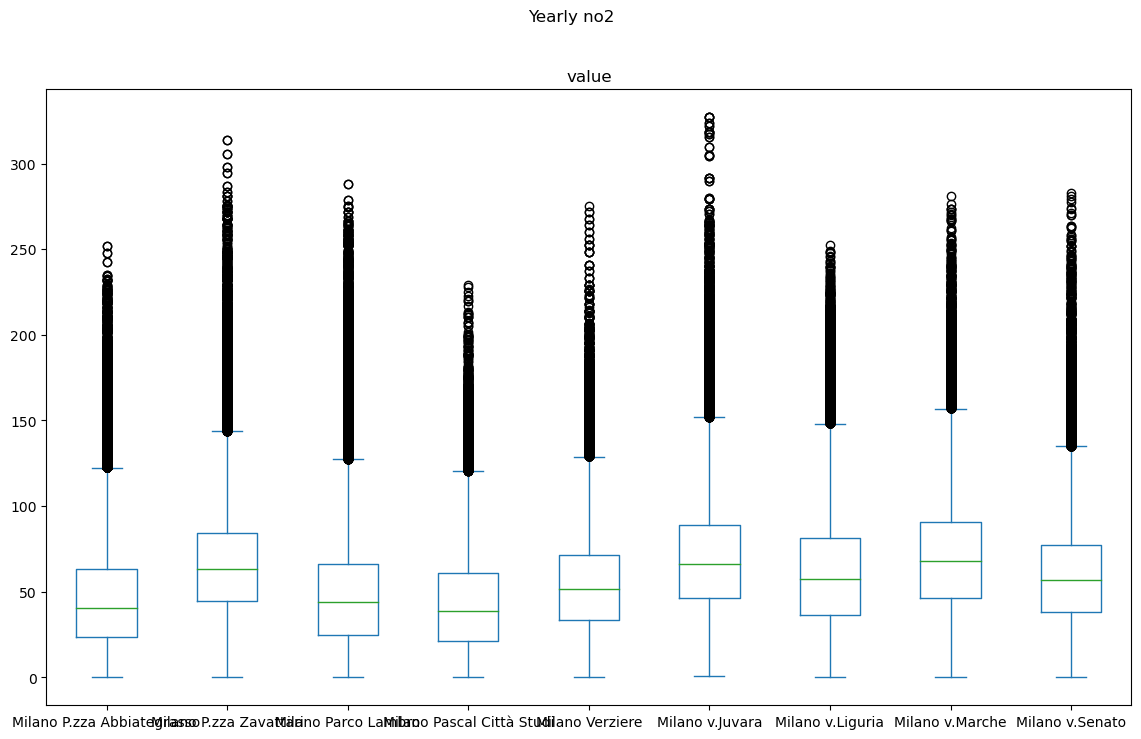

In [9]:
no2_data.plot.box(column="value", by="station", figsize=(14, 8), title='Yearly no2')

## Section 3 - Exceedence rate

Here we calculate the exceedence rate for each month of each year and for each sensor. The exceedence rate is the percentage of days in a month that a sensor reports that the no2 threshold has been exceeded. 

This gives us an idea of which months are more polluted in terms of no2 and also allows us to observe the variability in each sensor in the entire time range. With this, it is possible to check if the exceedence rates in different sensors are similar or different in the same month, meaning that there is also spatial variability in the no2 pollution.

In [10]:
#Calculate exceedance rate
no2_data_per_month = no2_data.copy()
no2_data_per_month = no2_data_per_month.assign(year=no2_data_per_month['date'].dt.year, month=no2_data_per_month['date'].dt.month)
no2_data_per_month = no2_data_per_month.drop(['date'], axis=1)
no2_data_per_month = no2_data_per_month.groupby(['year', 'month', 'lat', 'lng', 'sensor_id']).agg(exceed=('exceed', 'sum'), days_with_data=('value', 'count'), mean_value=('value', 'mean'))
#no2_data_per_month = no2_data_per_month.rename(columns={"value": "days_with_data"})
no2_data_per_month["exceeded_rate"] = (no2_data_per_month["exceed"] / no2_data_per_month["days_with_data"] * 100)
no2_data_per_month = no2_data_per_month.reset_index()
no2_data_per_month['t'] = no2_data_per_month['year'].astype(str) + '-' + no2_data_per_month['month'].astype(str)
no2_data_per_month

year  month        lat       lng  sensor_id  exceed  days_with_data  \
0     1998      1  45.432197  9.182139       5552    1276            1484   
1     1998      1  45.443858  9.167945       5542     689             742   
2     1998      1  45.463347  9.195325       5531     729             743   
3     1998      1  45.470499  9.197460       5551     732             742   
4     1998      1  45.473226  9.222315       5505    1434            1476   
...    ...    ...        ...       ...        ...     ...             ...   
2540  2023     12  45.526551  8.736497       5520      26             719   
2541  2023     12  45.534766  9.236108       5507     442             721   
2542  2023     12  45.548517  8.847322       5554      27             721   
2543  2023     12  45.551042  9.162614       5547     298             719   
2544  2023     12  45.552326  9.227764       5532     274             719   

      mean_value  exceeded_rate        t  
0      72.863747      85.983827   1998-1  
1      81.936658      92.857143   1998-1  
2      93.106326      98.115747   1998-1  
3      99.703639      98.652291   1998-1  
4      89.934282      97.154472   1998-1  
...          ...            ...      ...  
2540   27.621001       3.616134  2023-12  
2541   56.741470      61.303745  2023-12  
2542   28.283495       3.744799  2023-12  
2543   49.420028      41.446453  2023-12  
2544   49.326982      38.108484  2023-12  

[2545 rows x 10 columns]

In [11]:
no2_data_per_month.describe()

year        month          lat          lng     sensor_id  \
count  2545.000000  2545.000000  2545.000000  2545.000000   2545.000000   
mean   2010.925344     6.483301    45.471783     9.185570   5933.237721   
std       7.835068     3.453620     0.033095     0.080898   1315.407176   
min    1998.000000     1.000000    45.281956     8.736497   5504.000000   
25%    2004.000000     3.000000    45.463347     9.167945   5506.000000   
50%    2011.000000     6.000000    45.473226     9.195325   5542.000000   
75%    2017.000000     9.000000    45.496316     9.222315   5551.000000   
max    2023.000000    12.000000    45.552326     9.515980  10279.000000   

            exceed  days_with_data   mean_value  exceeded_rate  
count  2545.000000     2545.000000  2545.000000    2545.000000  
mean    466.609430      923.210609    54.425316      49.642356  
std     353.134707      340.769222    22.307541      30.871145  
min       0.000000        1.000000     7.257453       0.000000  
25%     183.000000      711.000000    37.465545      22.371968  
50%     412.000000      737.000000    53.389533      50.278552  
75%     650.000000     1344.000000    69.995062      78.091398  
max    1476.000000     1488.000000   138.486260      99.863760

In [12]:
no2_data_per_month.groupby(['month']).mean()

/tmp/ipykernel_39986/767771256.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  no2_data_per_month.groupby(['month']).mean()


year        lat       lng    sensor_id      exceed  \
month                                                              
1      2010.962617  45.471778  9.185900  5929.401869  729.757009   
2      2010.957746  45.471744  9.185667  5908.981221  650.938967   
3      2010.957746  45.471744  9.185667  5908.981221  575.112676   
4      2010.957746  45.471744  9.185667  5908.981221  400.431925   
5      2010.957746  45.471744  9.185667  5908.981221  324.704225   
6      2010.887324  45.471521  9.184351  5910.295775  274.835681   
7      2010.933962  45.471734  9.184423  5934.504717  267.849057   
8      2010.933333  45.472029  9.185916  5959.552381  187.190476   
9      2010.909953  45.471841  9.185898  5957.620853  407.080569   
10     2010.909953  45.471841  9.185898  5957.620853  520.459716   
11     2010.867299  45.471841  9.185898  5957.620853  578.744076   
12     2010.867299  45.471841  9.185898  5957.620853  679.099526   

       days_with_data  mean_value  exceeded_rate  
month                                             
1          935.219626   72.531208      76.250442  
2          875.201878   72.976404      73.083137  
3          955.737089   61.653313      59.245290  
4          917.178404   49.096219      42.760192  
5          937.169014   43.137628      33.779466  
6          912.633803   40.433583      29.320465  
7          929.202830   39.069838      27.604271  
8          932.414286   33.548047      19.204312  
9          906.175355   51.777121      44.479999  
10         941.862559   57.574535      55.030799  
11         906.729858   61.532497      63.159216  
12         929.018957   69.535576      71.467559

mean_value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

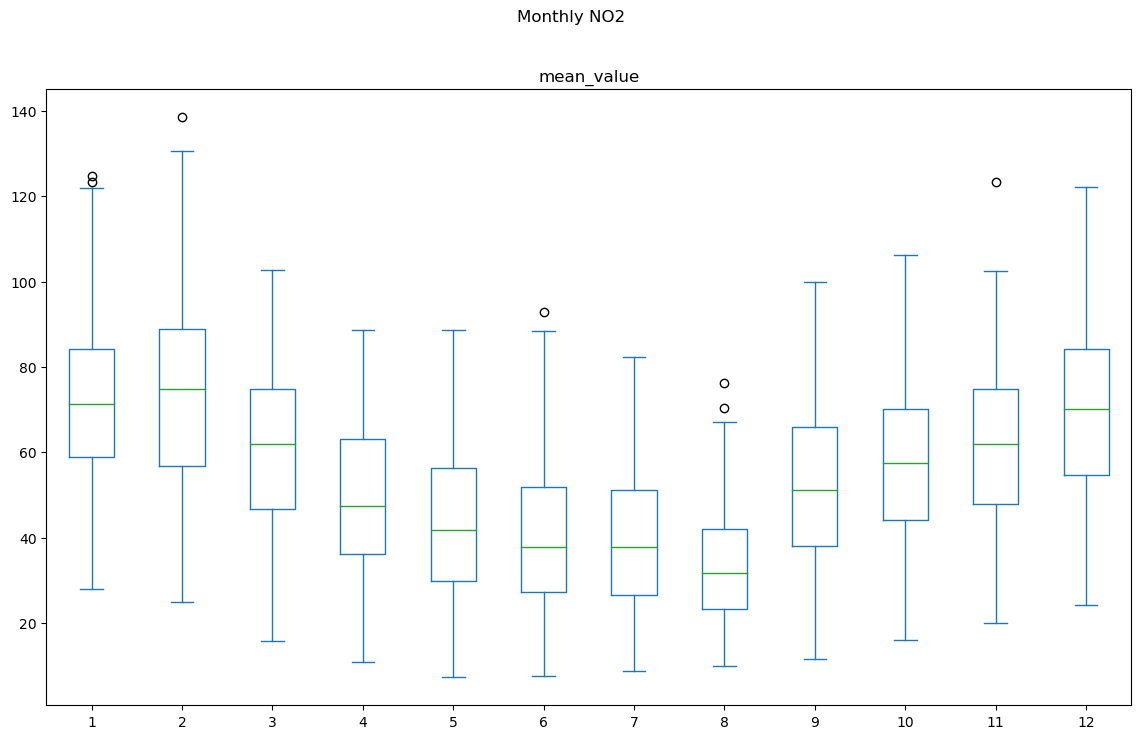

In [13]:
no2_data_per_month.plot.box(column="mean_value", by="month", figsize=(14, 8), title='Monthly NO2')

mean_value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

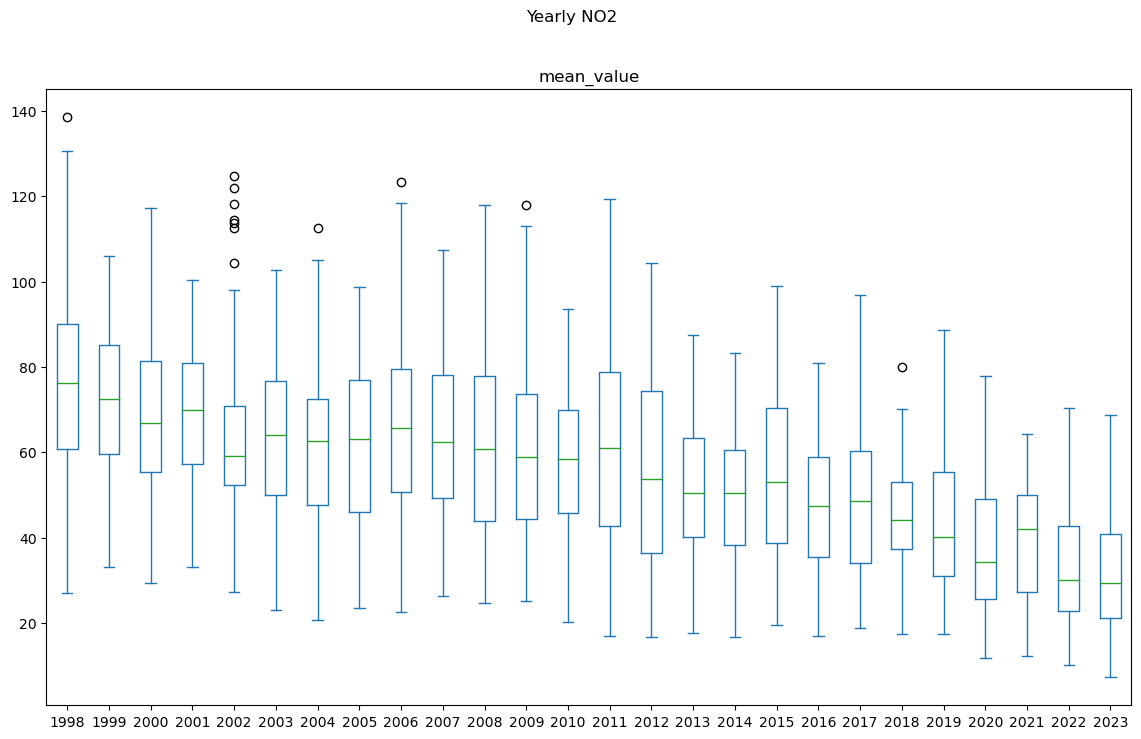

In [14]:
no2_data_per_month.plot.box(column="mean_value", by="year", figsize=(14, 8), title='Yearly NO2')

mean_value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

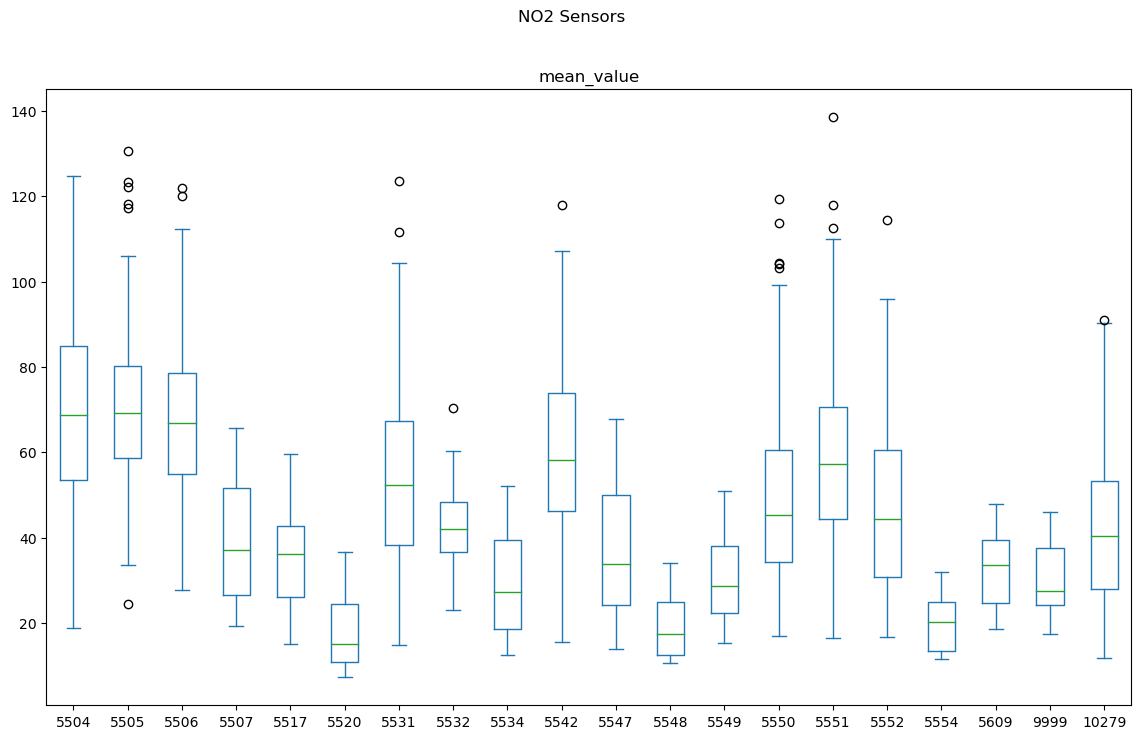

In [15]:
no2_data_per_month.plot.box(column="mean_value", by="sensor_id", figsize=(14, 8), title='NO2 Sensors')

In [16]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
names = {
    '5504': 'Milano v.Marche',
    '5505': 'Milano v.Juvara',
    '5506': 'Milano P.zza Zavattari',
    '5507': 'Sesto San Giovanni v. Cesare da Sesto',
    '5508': 'Legnano v.Diaz',
    '5511': 'Cassano d Adda v.di Vona',
    '5513': 'Inzago v.le Gramsci',
    '5514': 'Abbiategrasso v. Serafino Dell Uomo',
    '5516': 'Trezzo sull Adda v.Nenni',
    '5517': 'Rho via Buon Gesù',
    '5518': 'Pero SS Sempione',
    '5519': 'Robecchetto con Induno v. Pertini',
    '5520': 'Turbigo vicolo dello sport',
    '5522': 'Tribiano',
    '5528': 'Corsico v.le Italia',
    '5530': 'Castano Primo v. Olimpiadi',
    '5531': 'Milano Verziere',
    '5532': 'Cinisello Balsamo v.Lincoln',
    '5534': 'Pioltello Limito',
    '5535': 'Cuggiono v. Languria',
    '5538': 'Lacchiarella v.Molise',
    '5539': 'Arese v. Matteotti',
    '5540': 'Lainate v.Mengato',
    '5541': 'Settimo Milanese v. Della Libertà',
    '5542': 'Milano v.Liguria',
    '5543': 'Garbagnate Milanese v. Villoresi',
    '5547': 'Cormano v. Edison',
    '5548': 'Motta Visconti v. De Gasperi',
    '5549': 'Magenta v. F. Turati',
    '5550': 'Milano Parco Lambro',
    '5551': 'Milano v.Senato',
    '5552': 'Milano P.zza Abbiategrasso',
    '5554': 'Arconate v. De Gasperi',
    '5605': 'Melegnano v.Predabissi',
    '5609': 'San Giuliano Milanese via Milano',
    '9999': 'Cassano d Adda 2-v.Milano',
    '10005': 'Truccazzano via Fornasino',
    '10279': 'Milano Pascal Città Studi',
}

In [18]:
sensors = list(no2_data.sensor_id.unique())
#sensors = [5504,5505,5506,5507,5508,5511,5513,5514,5516,5517,5518,5519,5520,5522,5528,5530,5531,5532,5534,5535,5538,5539,5540,5541,5542,5543,5547,5548,5549,5550,5551,5552,5554,5605,5609,9999,10005,10279]
# Plot the exceedence rate per sensor too see if there is variation in time
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = no2_data_per_month.loc[no2_data_per_month['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))
    #plot_names.append(str(sensor))

plot_columns_x = ['t'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)

show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names, limits=[{'thr': no2_daily_threshold, 'name':'Daily limit'}], print=False)

In [19]:
sensors = list(no2_data.sensor_id.unique())
#sensors = [6905,6956,10273,10320,20035]
# Plot the exceedence rate per sensor too see if there is variation in time
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = no2_data_per_month.loc[no2_data_per_month['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['t'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)
    
show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names)

In [21]:
#Calculate exceedance rate
no2_data_per_year = no2_data.copy()
no2_data_per_year = no2_data_per_year.assign(year=no2_data_per_year['date'].dt.year)
no2_data_per_year = no2_data_per_year.drop(['date'], axis=1)
no2_data_per_year = no2_data_per_year.groupby(['year', 'lat', 'lng', 'sensor_id']).agg(exceed=('exceed', 'sum'), days_with_data=('value', 'count'), mean_value=('value', 'mean'))
#no2_data_per_month = no2_data_per_month.rename(columns={"value": "days_with_data"})
no2_data_per_year = no2_data_per_year.reset_index()
#no2_data_per_year['t'] = no2_data_per_year['year'].astype(str) + '-' + no2_data_per_year['month'].astype(str)
no2_data_per_year

year        lat       lng  sensor_id  exceed  days_with_data  mean_value
0    1998  45.432197  9.182139       5552    8365           16295   54.772501
1    1998  45.443858  9.167945       5542    6158            8324   74.011881
2    1998  45.463347  9.195325       5531    7272            8618   83.948143
3    1998  45.470499  9.197460       5551    5254            6384   82.645724
4    1998  45.473226  9.222315       5505   14546           17038   89.716223
..    ...        ...       ...        ...     ...             ...         ...
210  2023  45.526551  8.736497       5520     125            8221   15.940056
211  2023  45.534766  9.236108       5507    2101            8421   37.477520
212  2023  45.548517  8.847322       5554     178            7817   19.999808
213  2023  45.551042  9.162614       5547    1865            8604   33.699070
214  2023  45.552326  9.227764       5532    2515            8657   41.908398

[215 rows x 7 columns]

In [23]:
no2_data_per_year['exceed'] = np.where(no2_data_per_year['mean_value'].gt(no2_yearly_threshold), 1, 0)
no2_data_per_year["exceeded_rate"] = (no2_data_per_year["exceed"] / no2_data_per_year["days_with_data"] * 100)
no2_data_per_year

year        lat       lng  sensor_id  exceed  days_with_data  mean_value  \
0    1998  45.432197  9.182139       5552       1           16295   54.772501   
1    1998  45.443858  9.167945       5542       1            8324   74.011881   
2    1998  45.463347  9.195325       5531       1            8618   83.948143   
3    1998  45.470499  9.197460       5551       1            6384   82.645724   
4    1998  45.473226  9.222315       5505       1           17038   89.716223   
..    ...        ...       ...        ...     ...             ...         ...   
210  2023  45.526551  8.736497       5520       0            8221   15.940056   
211  2023  45.534766  9.236108       5507       0            8421   37.477520   
212  2023  45.548517  8.847322       5554       0            7817   19.999808   
213  2023  45.551042  9.162614       5547       0            8604   33.699070   
214  2023  45.552326  9.227764       5532       1            8657   41.908398   

     exceeded_rate  
0         0.006137  
1         0.012013  
2         0.011604  
3         0.015664  
4         0.005869  
..             ...  
210       0.000000  
211       0.000000  
212       0.000000  
213       0.000000  
214       0.011551  

[215 rows x 8 columns]

In [24]:
no2_data_per_year.groupby(['year']).mean()

lat       lng    sensor_id    exceed  days_with_data  mean_value  \
year                                                                           
1998  45.469386  9.193154  5530.125000  1.000000    12377.625000   76.739176   
1999  45.469386  9.193154  5530.125000  1.000000    12891.875000   71.330897   
2000  45.469386  9.193154  5530.125000  1.000000    12930.875000   68.340216   
2001  45.469386  9.193154  5530.125000  1.000000    12878.000000   67.942303   
2002  45.469386  9.193154  5530.125000  1.000000    12912.250000   63.557524   
2003  45.469386  9.193154  5530.125000  1.000000    12733.375000   63.866622   
2004  45.469386  9.193154  5530.125000  1.000000    12780.375000   60.716109   
2005  45.469386  9.193154  5530.125000  1.000000    12438.250000   60.741602   
2006  45.469386  9.193154  5530.125000  1.000000    11684.125000   66.382318   
2007  45.470454  9.197858  6057.777778  1.000000    10492.777778   62.992237   
2008  45.470108  9.194801  6126.875000  1.000000    10624.500000   60.912234   
2009  45.470108  9.194801  6126.875000  1.000000    11576.625000   60.377489   
2010  45.470108  9.194801  6126.875000  1.000000    11602.625000   57.644505   
2011  45.470108  9.194801  6126.875000  1.000000    11349.500000   60.295036   
2012  45.470108  9.194801  6126.875000  0.875000    11070.375000   54.435437   
2013  45.470108  9.194801  6126.875000  0.875000    11222.625000   51.807325   
2014  45.470108  9.194801  6126.875000  0.875000    11470.500000   48.839238   
2015  45.470108  9.194801  6126.875000  0.875000    11117.000000   54.114178   
2016  45.470108  9.194801  6126.875000  0.750000    11239.875000   48.996393   
2017  45.470108  9.194801  6126.875000  0.750000    10896.750000   47.833119   
2018  45.465897  9.187297  6209.285714  0.714286     8380.428571   44.145272   
2019  45.470603  9.197431  6481.400000  0.400000     8324.800000   43.218694   
2020  45.470603  9.197431  6481.400000  0.400000     8470.000000   38.532902   
2021  45.470603  9.197431  6481.400000  0.600000     8325.600000   38.981359   
2022  45.483770  9.139805  6113.937500  0.125000     8305.812500   33.174255   
2023  45.483770  9.139805  6113.937500  0.125000     8225.062500   30.940281   

      exceeded_rate  
year                 
1998       0.009356  
1999       0.008732  
2000       0.008726  
2001       0.008760  
2002       0.008733  
2003       0.008810  
2004       0.008795  
2005       0.008948  
2006       0.009432  
2007       0.011314  
2008       0.010144  
2009       0.009612  
2010       0.009634  
2011       0.009903  
2012       0.008147  
2013       0.008981  
2014       0.008955  
2015       0.009019  
2016       0.008369  
2017       0.008330  
2018       0.008651  
2019       0.004781  
2020       0.004719  
2021       0.007231  
2022       0.001462  
2023       0.001496

In [ ]:
no2_data_per_year.hist(bins=50, figsize=(20,15))

In [26]:

sensors = list(no2_data.sensor_id.unique())
#sensors = [6905,6956,10273,10320,20035]
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = no2_data_per_year.loc[no2_data_per_year['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['year'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)
    
show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names, limits=[{'thr': no2_yearly_threshold, 'name':'Yearly limit'}], print=False)

In [ ]:

sensors = list(no2_data.sensor_id.unique())
#sensors = [6905,6956,10273,10320,20035]
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = no2_data_per_year.loc[no2_data_per_year['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['year'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)
    
show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names, limits=[{'thr': 20, 'name':'Yearly limit'}], print=False)

## Section 4 - Interpolation

Here we create a interpolation of the data in the entire comune of Milano using the available in-situ data from the stations for a specific month of the entire time range. We show only the results for January 2020 with Nearest Neighboors, Krigging, and with Inverse Distance Weighted interpolation methods.

In [23]:
# General variables
milano_shapefile_path = '../../data/milano_final_shapefile/milano_metro.shp'
xdelta = 1000 #1000 meter separation for grid in x coordinates
ydelta = 1000 #1000 meter separation for grid in y coordinates

In [21]:
month_average_exceedence_rate = no2_data_per_month.groupby(["month", "lat", "lng", "sensor_id"]).mean(numeric_only=True)
month_average_exceedence_rate = month_average_exceedence_rate.drop(columns=["days_with_data", "exceed", "year"])
month_average_exceedence_rate = month_average_exceedence_rate.reset_index()
month_average_exceedence_rate

month        lat       lng  sensor_id  mean_value  exceeded_rate
0        1  45.281956  8.988563       5548   31.317483       9.284478
1        1  45.396195  9.282700       5609   44.373945      33.969913
2        1  45.432197  9.182139       5552   66.670044      68.823232
3        1  45.443858  9.167945       5542   79.613771      85.443388
4        1  45.443858  9.167945       5542   53.883998      54.573560
..     ...        ...       ...        ...         ...            ...
295     12  45.526551  8.736497       5520   25.954108       2.009951
296     12  45.534766  9.236108       5507   51.597622      48.172088
297     12  45.548517  8.847322       5554   26.459680       2.276277
298     12  45.551042  9.162614       5547   50.465256      46.529678
299     12  45.552326  9.227764       5532   47.727413      35.820709

[300 rows x 6 columns]

Month 1
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



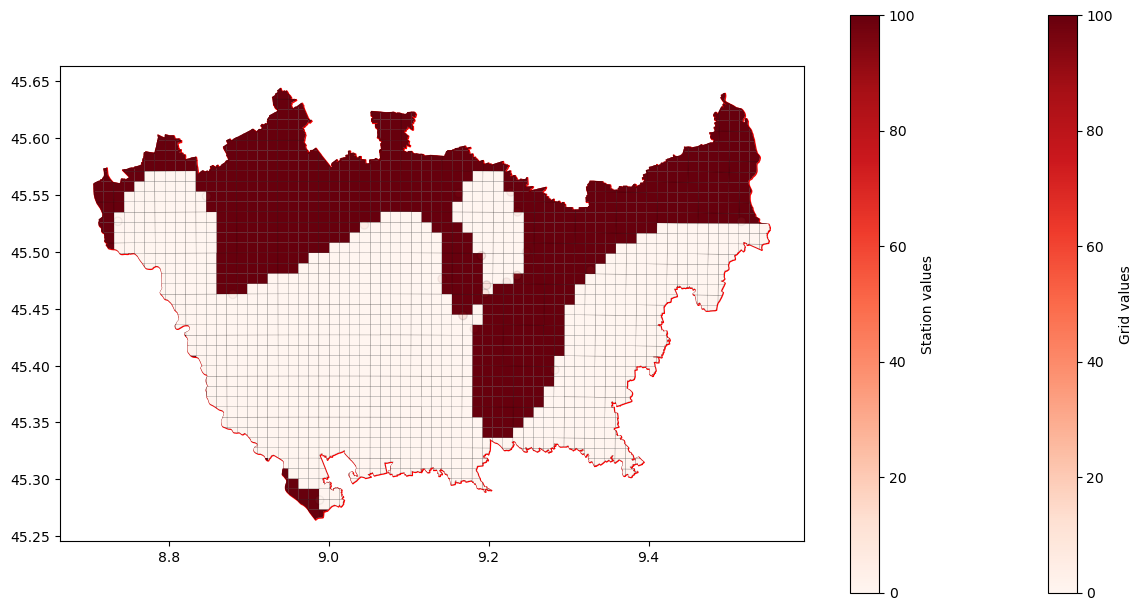

----------------------------------------------------------------------
Month 2
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



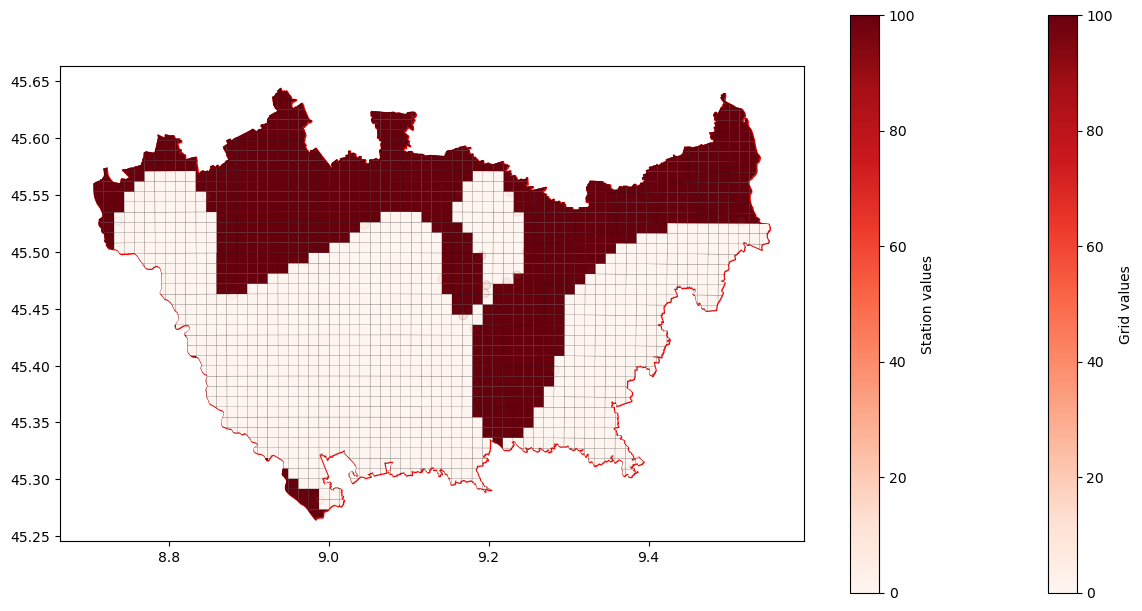

----------------------------------------------------------------------
Month 3
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



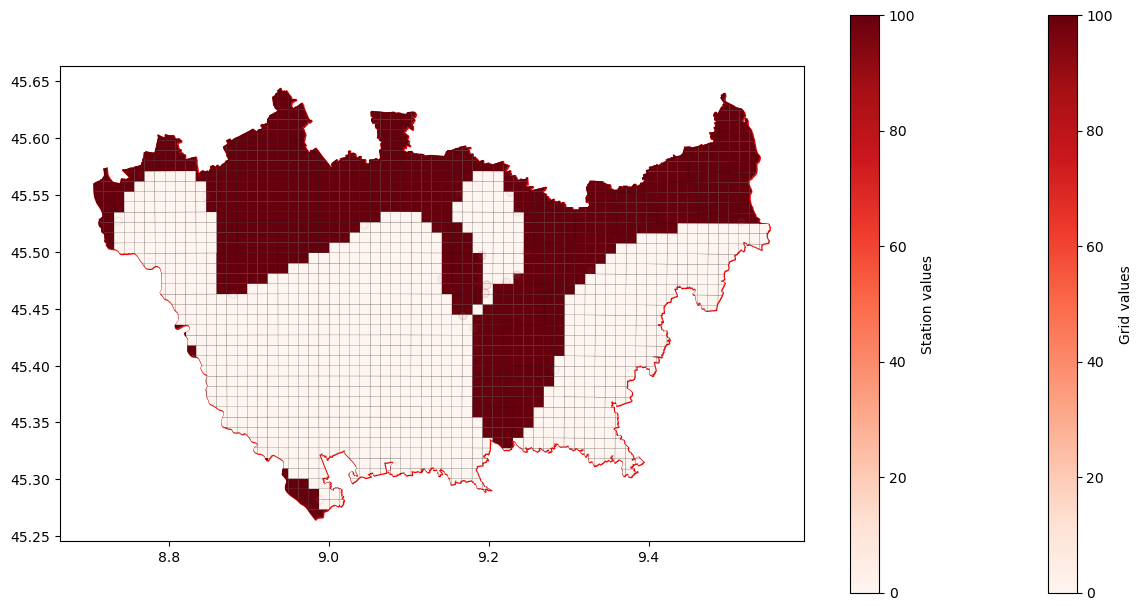

----------------------------------------------------------------------
Month 4
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



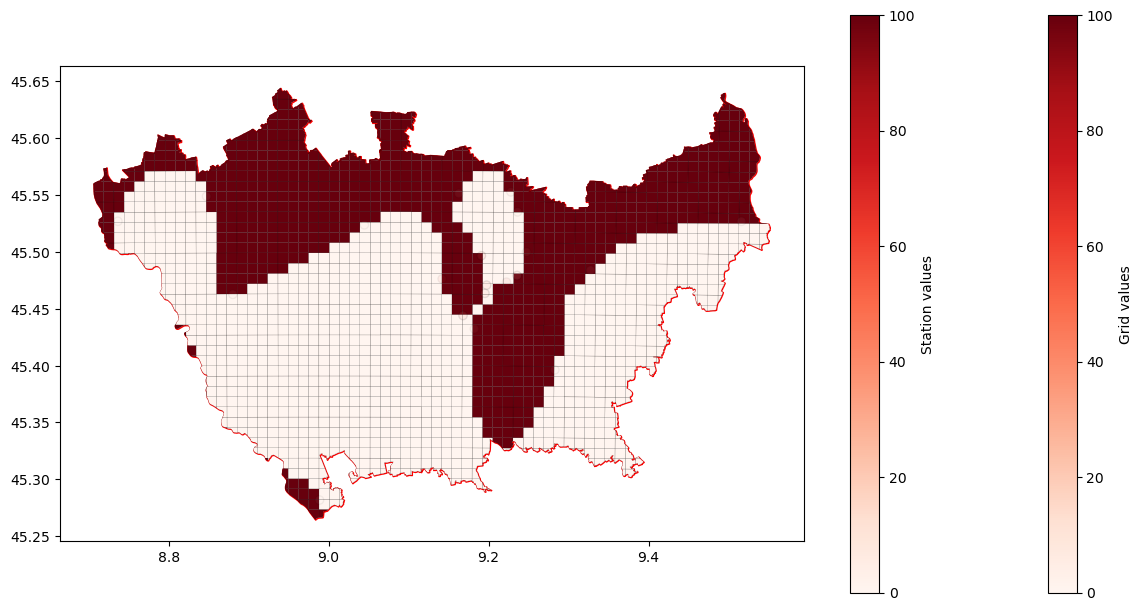

----------------------------------------------------------------------
Month 5
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



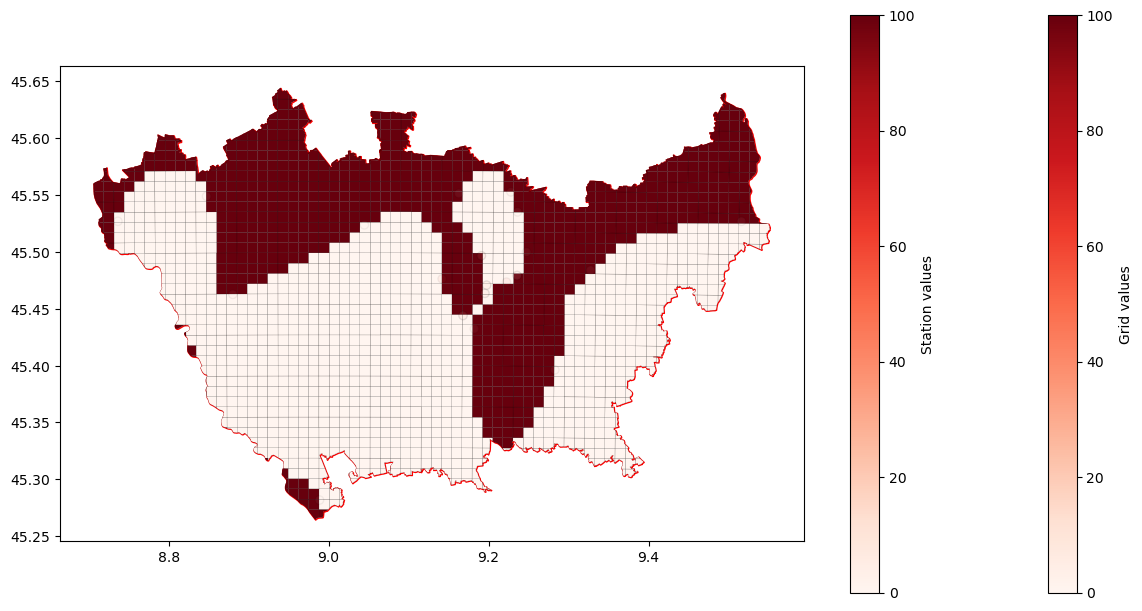

----------------------------------------------------------------------
Month 6
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



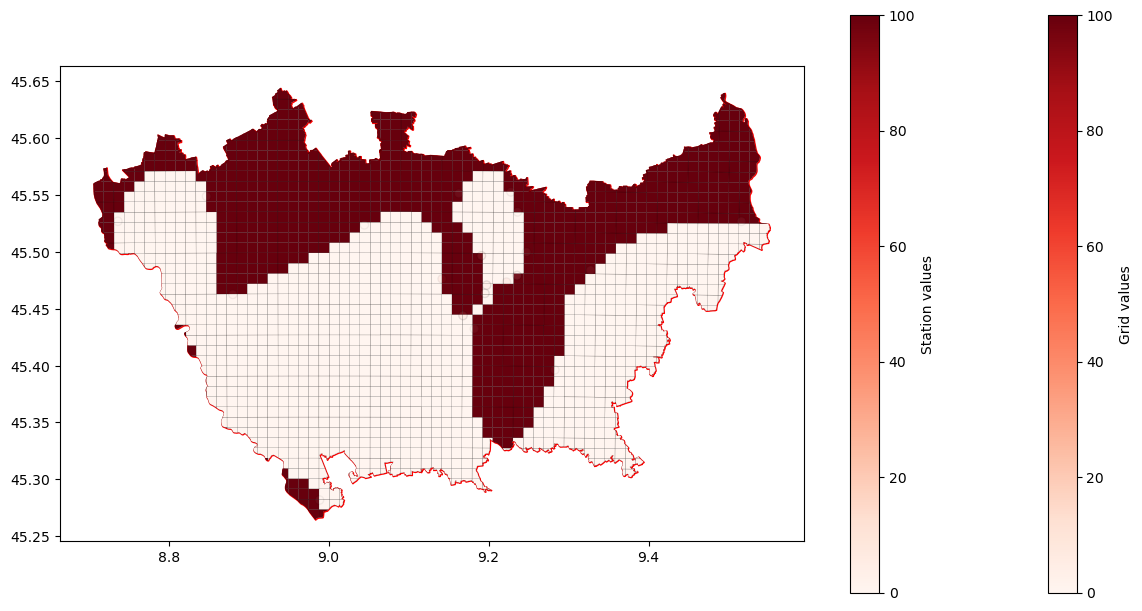

----------------------------------------------------------------------
Month 7
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



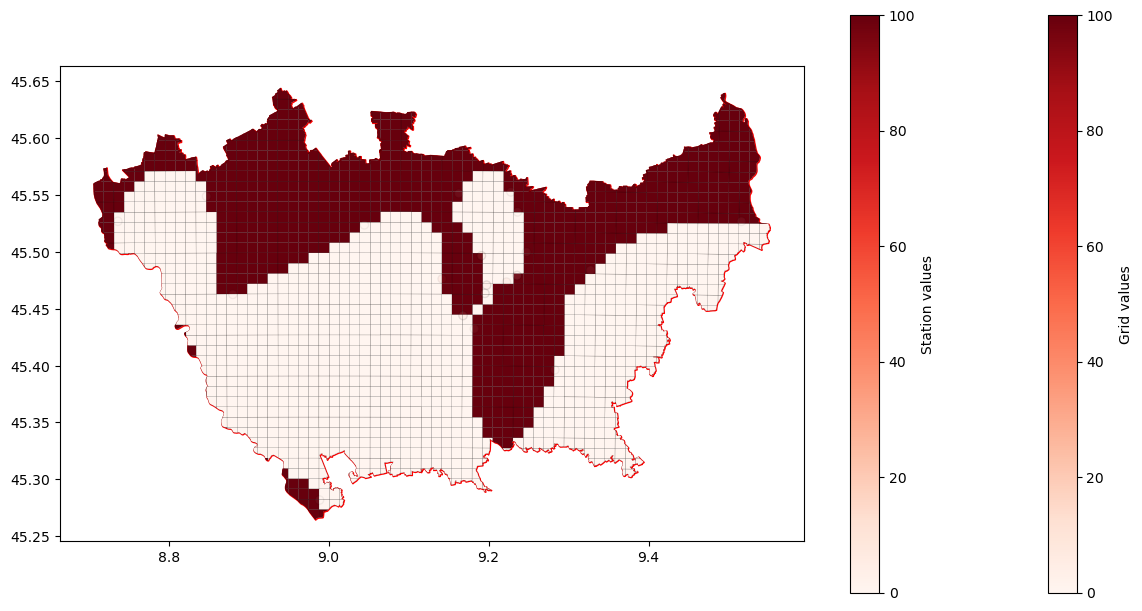

----------------------------------------------------------------------
Month 8
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



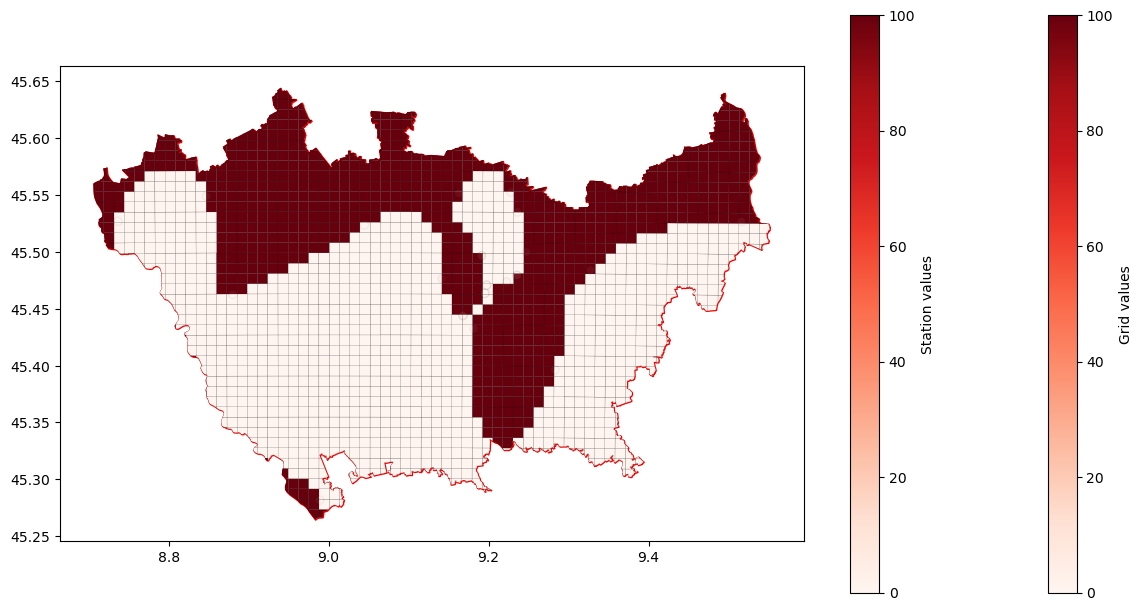

----------------------------------------------------------------------
Month 9
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



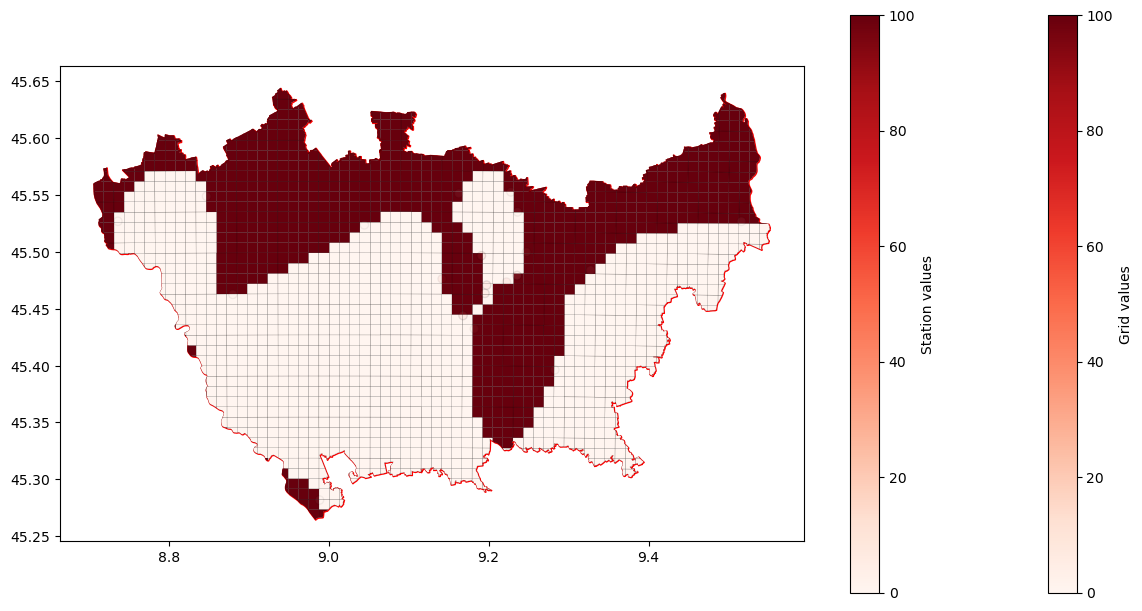

----------------------------------------------------------------------
Month 10
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



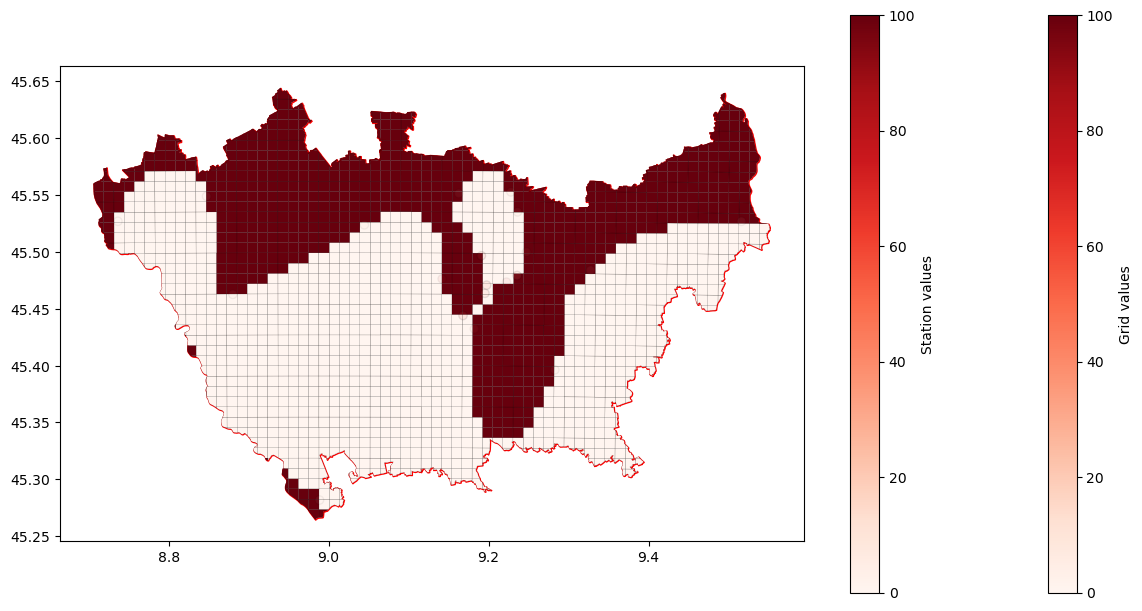

----------------------------------------------------------------------
Month 11
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



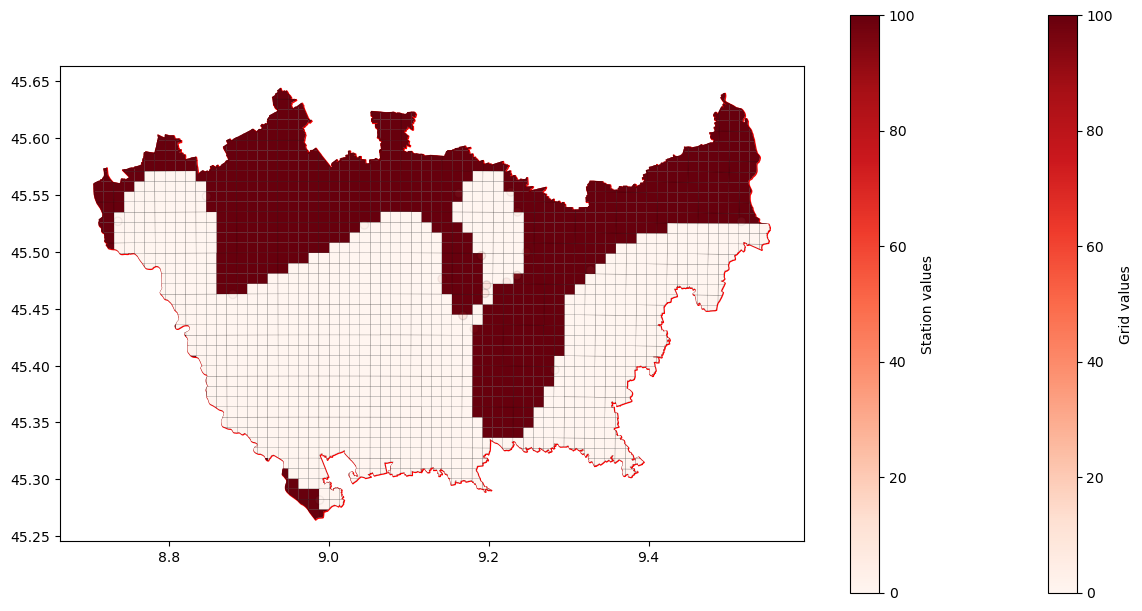

----------------------------------------------------------------------
Month 12
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/scipy/interpolate/_rbf.py:266: LinAlgWarning:

Ill-conditioned matrix (rcond=5.34993e-19): result may not be accurate.



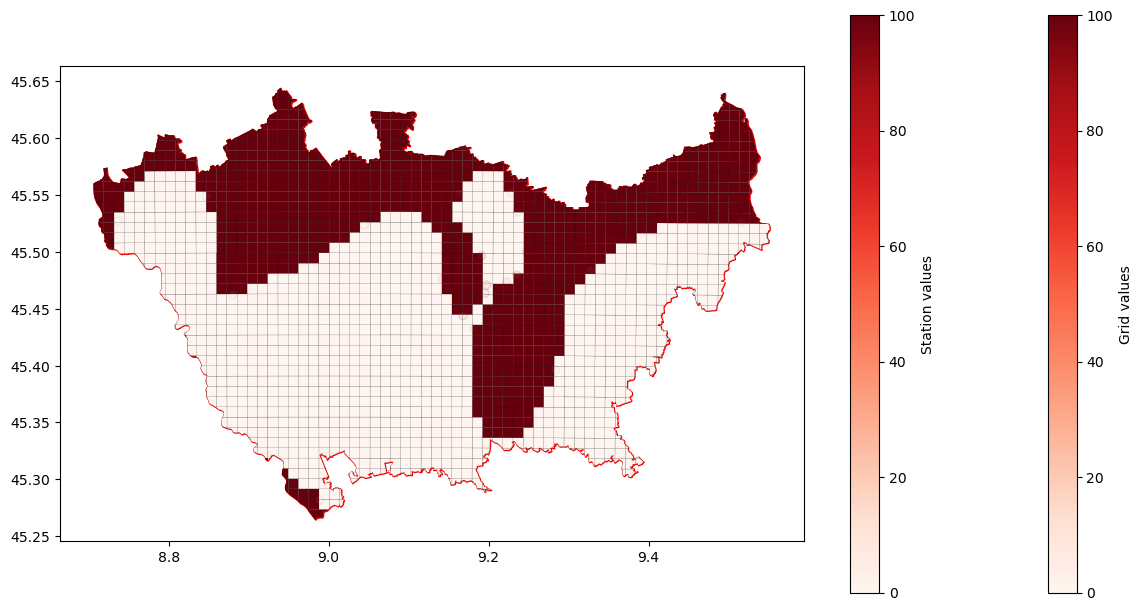

----------------------------------------------------------------------


In [24]:
#Interpolation over the map for the average exceeded rates for each month 

for month in range(1,13):
    print(f"Month {month}")
    no2_interpolation = month_average_exceedence_rate.loc[
        (month_average_exceedence_rate['month'] == month) 
    ]
    no2_grid, no2_interpolation_df = interp.interpolate(
        'exceeded_rate', 
        'IDW', 
        milano_shapefile_path, 
        no2_interpolation, 
        xdelta=xdelta, 
        ydelta=ydelta
    )
    print("----------------------------------------------------------------------")